In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import xgboost as xgb

/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

In [3]:
properties = pd.read_csv('Input/properties_2016.csv').fillna(np.nan)
train_orig = pd.read_csv("Input/train_2016_v2.csv", parse_dates=['transactiondate']).fillna(np.nan)

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Read description of the features and cleaning it (removing ""/'' )
zillow_dictionary = pd.read_excel('Input/zillow_data_dictionary.xlsx', index_col=0)
zillow_dictionary.index = [re.findall('\w+', str(index))[0] for _,index in enumerate(zillow_dictionary.index)]
zillow_dictionary = zillow_dictionary.to_dict()

In [5]:
df_train = pd.merge(properties, train_orig, on = 'parcelid', how = 'left')
df_prdct = df_train[df_train.logerror.isnull() == True]
df_train = df_train[df_train.logerror.isnull() == False]

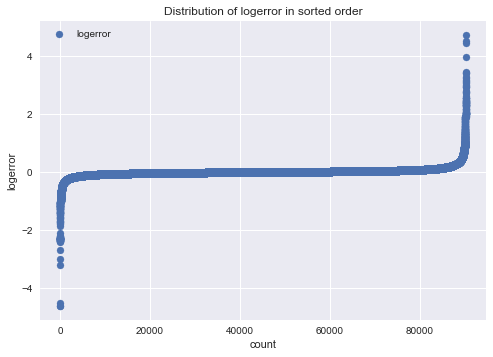

In [6]:
plt.cla()
plt.scatter(np.arange(df_train.shape[0]), np.sort(df_train.logerror), label = 'logerror')
plt.ylabel('logerror')
plt.xlabel('count')
plt.title('Distribution of logerror in sorted order')
plt.legend()
plt.show()

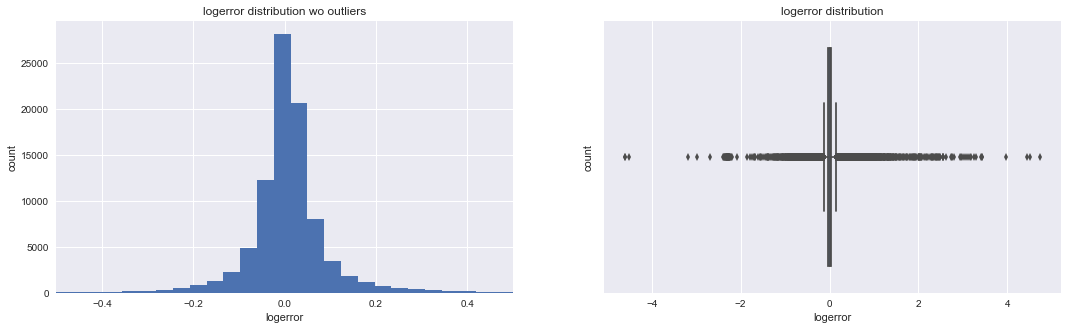

In [7]:
plt.subplots(1, 2, figsize = (18,5))
plt.subplot(1, 2, 1)
plt.hist(df_train[(df_train['logerror'] < 0.71353)&(df_train['logerror'] > -0.5042)].logerror, bins = 33)
plt.xlim(-0.5,0.5)
plt.ylabel('count')
plt.xlabel('logerror')
plt.title('logerror distribution wo outliers')

plt.subplot(1, 2, 2)
sns.boxplot(df_train.logerror)
plt.ylabel('count')
plt.xlabel('logerror')
plt.title('logerror distribution')
plt.show()

In [8]:
print 'Log error 0.5, 99.5 percentiles: ',np.percentile(df_train.logerror, [0.5,99.5])

Log error 0.5, 99.5 percentiles:  [-0.5042   0.71353]


In [9]:
df_train['abs_logerror'] = np.abs(df_train.logerror)

In [10]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

Let's separate features by type: counted, category, etc.

In [77]:
cat_features = [re.findall('\w+', str(key))[0] 
                                 for key in zillow_dictionary['Description'].iterkeys()
                                 if (re.search('id', key) or re.search('code', key) or re.search('flag', key))] + \
                                ['fips', 'hashottuborspa', 'propertyzoningdesc', 'rawcensustractandblock',
                                'censustractandblock']

count_features = [re.findall('\w+', str(key))[0] 
                                 for key in zillow_dictionary['Description'].iterkeys()
                                 if (re.search('cnt', key) or re.search('nbr', key) or re.search('number', key))]

num_features = properties.columns.drop(cat_features + count_features)

In [12]:
del_features = []

In [13]:
df_features = pd.DataFrame(index=df_train.columns)
df_features['n_unique_Training'] = [len(df_train.loc[:,feature].unique())        for feature in df_features.index]
df_features['n_unique_Prop']     = [len(properties.loc[:,feature].unique())  if feature in properties.columns \
                                    else np.nan for feature in df_features.index]
df_features['%_nans_Training']   = [round((100. * df_train.loc[:,feature].isnull().sum()/df_train.shape[0]), 2) \
                                    for feature in df_features.index]

In [14]:
df_features.sort_values('n_unique_Training', inplace=True)

In [15]:
df_features.head(10)

,n_unique_Training,n_unique_Prop,%_nans_Training
assessmentyear,1,15.0,0.00
pooltypeid2,2,2.0,98.67
pooltypeid7,2,2.0,81.50
pooltypeid10,2,2.0,98.71
poolcnt,2,2.0,80.17
buildingclasstypeid,2,6.0,99.98
hashottuborspa,2,2.0,97.38
storytypeid,2,2.0,99.95
decktypeid,2,2.0,99.27
taxdelinquencyflag,2,2.0,98.02


In [16]:
del_features.append('assessmentyear')
del_features.append('parcelid')

In [17]:
df_features.loc[cat_features, :]

,n_unique_Training,n_unique_Prop,%_nans_Training
fireplaceflag,2,2.0,99.75
regionidcity,178,187.0,2.00
regionidzip,389,406.0,0.04
typeconstructiontypeid,4,6.0,99.67
buildingclasstypeid,2,6.0,99.98
regionidcounty,3,4.0,0.00
taxdelinquencyflag,2,2.0,98.02
pooltypeid10,2,2.0,98.71
storytypeid,2,2.0,99.95
buildingqualitytypeid,9,13.0,36.46


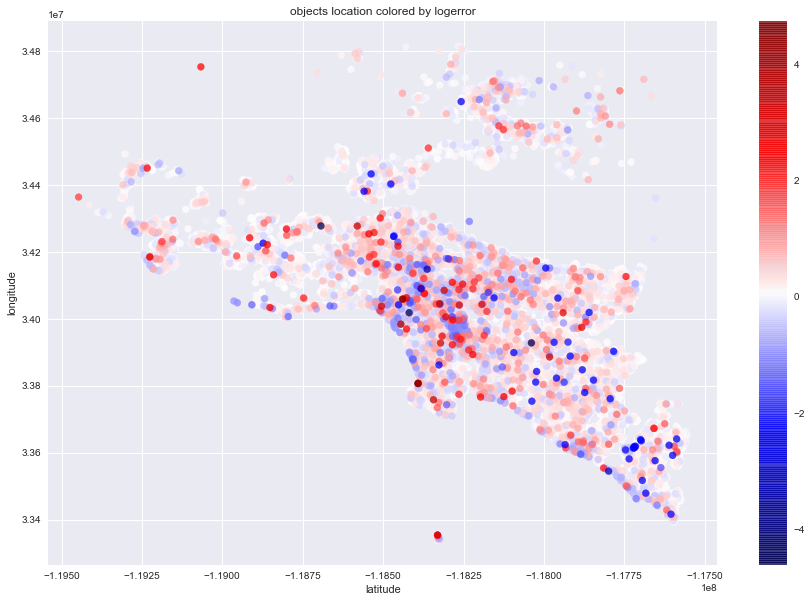

In [18]:
plt.subplots(figsize = (15,10))
x = df_train.sort_values('abs_logerror').longitude
y = df_train.sort_values('abs_logerror').latitude
B = df_train.sort_values('abs_logerror').logerror

cs = plt.scatter(x, y, c=B, cmap = plt.cm.seismic,
                 vmin  = np.min(B),
                 vmax  = np.max(B),
                 alpha = 0.75)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('objects location colored by logerror')
plt.colorbar(cs)
plt.show()

In [19]:
del_features

['assessmentyear', 'parcelid']

In [87]:
df_features.loc[num_features,:].drop(del_features, axis = 'rows', errors = 'ignore')

,n_unique_Training,n_unique_Prop,%_nans_Training
basementsqft,40,752.0,99.95
finishedfloor1squarefeet,1887,4605.0,92.41
calculatedfinishedsquarefeet,5103,12588.0,0.73
finishedsquarefeet12,4983,10671.0,5.18
finishedsquarefeet13,12,251.0,99.96
finishedsquarefeet15,1916,8817.0,96.05
finishedsquarefeet50,1899,4803.0,92.41
finishedsquarefeet6,361,4252.0,99.53
garagetotalsqft,871,2241.0,66.84
latitude,73312,852326.0,0.00


Let's check if timeseries values in 'yearbuilt' and 'taxdelinquencyyear' in training data are earlier than in data to be predicted. It's strongly recomended not to use training data with timeseries values greater than in data to be predicted because we shouldn't to predict 'past' by 'future' in order to model not to be overfitted.

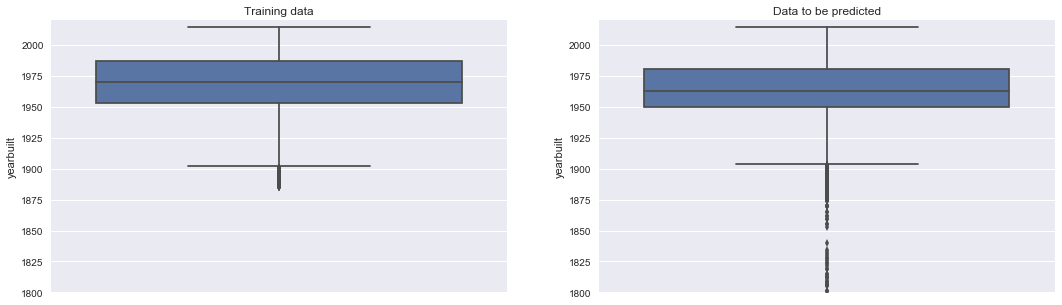

In [21]:
plt.subplots(1, 2, figsize = (18,5), sharey=True)
plt.subplot(1, 2, 1)
sns.boxplot(y = 'yearbuilt', data = df_train)
plt.title('Training data')
plt.ylim(1800, 2020)
plt.subplot(1, 2, 2)
plt.title('Data to be predicted')
sns.boxplot(y = 'yearbuilt', data = df_prdct)
plt.ylim(1800, 2020)
plt.show()

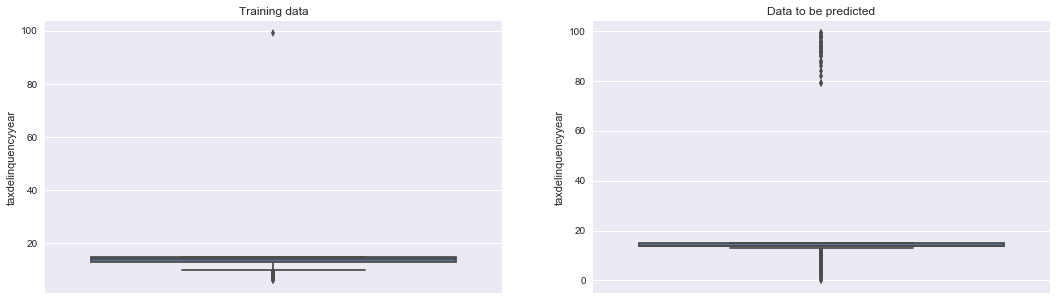

In [22]:
plt.subplots(1, 2, figsize = (18,5), sharey=True)
plt.subplot(1, 2, 1)
sns.boxplot(y = 'taxdelinquencyyear', data = df_train)
plt.title('Training data')
#plt.ylim(1800, 2020)
plt.subplot(1, 2, 2)
plt.title('Data to be predicted')
sns.boxplot(y = 'taxdelinquencyyear', data = df_prdct)
#plt.ylim(1800, 2020)
plt.show()

So as we can see max values of timeseries from training data covers min ones from data to be predicted. However we can try to separate timeseries values in 'yearbuilt' like 'early values in training, later values in pred.' and fill dopped values by nans. It's the possible way for further improvements of the model.

Moreover we should drop 'taxdelinquencyyear' because ~98% of

In [23]:
zillow_dictionary['Description']['taxdelinquencyyear']

u'Year for which the unpaid propert taxes were due '

In [24]:
df_train.taxdelinquencyyear.unique()[1:].shape

(11,)

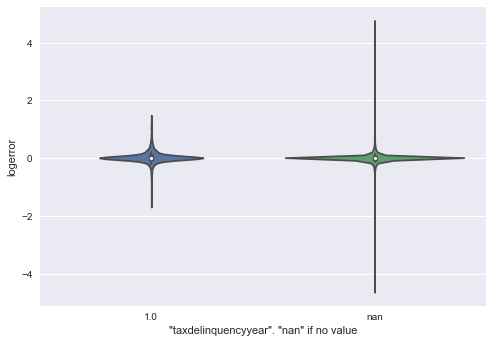

In [25]:
sns.violinplot(df_train.taxdelinquencyyear.replace(df_train.taxdelinquencyyear.unique()[1:],
                                                  np.ones((11,))).fillna('nan'),
               df_train.logerror)
plt.xlabel('"taxdelinquencyyear". "nan" if no value')
plt.show()

As we can see logerror for the objects with null values of 'taxdelinquencyyear' tends to be higher on outliers. It can be caused by being feature extremely unbalanced: ~98% of training data's 'taxdelinquencyyear' consists of 'nan's.
Let's move this feature into 'categorical' list.

In [26]:
cat_features.append('taxdelinquencyyear')
num_features = num_features.delete(np.argwhere(num_features == 'taxdelinquencyyear'))

In [85]:
df_features.loc[count_features,:].drop(del_features, axis = 'rows', errors = 'ignore')

,n_unique_Training,n_unique_Prop,%_nans_Training
numberofstories,5,13.0,77.21
fireplacecnt,6,10.0,89.36
poolcnt,2,2.0,80.17
threequarterbathnbr,5,8.0,86.70
roomcnt,17,37.0,0.00
bedroomcnt,17,22.0,0.00
unitcnt,11,147.0,35.36
garagecarcnt,16,25.0,66.84
fullbathcnt,15,21.0,1.31
calculatedbathnbr,23,35.0,1.31


In [86]:
for ind in df_features.loc[count_features,:].drop(del_features, axis = 'rows', errors = 'ignore').iterrows():
    print ind[0], ':\n \t is ', zillow_dictionary['Description'][ind[0]]

numberofstories :
 	 is   Number of stories or levels the home has
fireplacecnt :
 	 is   Number of fireplaces in a home (if any)
poolcnt :
 	 is   Number of pools on the lot (if any)
threequarterbathnbr :
 	 is   Number of 3/4 bathrooms in house (shower + sink + toilet)
roomcnt :
 	 is   Total number of rooms in the principal residence
bedroomcnt :
 	 is   Number of bedrooms in home 
unitcnt :
 	 is   Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)
garagecarcnt :
 	 is   Total number of garages on the lot including an attached garage
fullbathcnt :
 	 is   Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
calculatedbathnbr :
 	 is   Number of bathrooms in home including fractional bathroom
bathroomcnt :
 	 is   Number of bathrooms in home including fractional bathrooms


Looks like 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt' and 'taxvaluedollarcnt' were misclassified and should be relocated into list of numerical features.

In [81]:
features_to_replace = ['structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt']
num_features = np.hstack([num_features, features_to_replace])

In [82]:
count_features = [feature for _, feature in enumerate(count_features) if feature not in features_to_replace ]

In [83]:
num_features

array(['basementsqft', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'garagetotalsqft',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolsizesum',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'assessmentyear', 'taxamount', 'taxdelinquencyyear',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'taxvaluedollarcnt'], dtype=object)

In [84]:
count_features

['numberofstories',
 'fireplacecnt',
 'poolcnt',
 'threequarterbathnbr',
 'roomcnt',
 'bedroomcnt',
 'unitcnt',
 'garagecarcnt',
 'fullbathcnt',
 'calculatedbathnbr',
 'bathroomcnt']

In [90]:
df_features.loc[cat_features,:].drop(del_features, axis = 'rows', errors = 'ignore')

,n_unique_Training,n_unique_Prop,%_nans_Training
fireplaceflag,2,2.0,99.75
regionidcity,178,187.0,2.00
regionidzip,389,406.0,0.04
typeconstructiontypeid,4,6.0,99.67
buildingclasstypeid,2,6.0,99.98
regionidcounty,3,4.0,0.00
taxdelinquencyflag,2,2.0,98.02
pooltypeid10,2,2.0,98.71
storytypeid,2,2.0,99.95
buildingqualitytypeid,9,13.0,36.46


Now lets use bootstrap statisctics to spot if any values of cat features refer to larger values of logerror.

In [171]:
def get_bootstrap_samples (data, n_samples = 1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices]

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [172]:
fips_01_samples = get_bootstrap_samples(df_train.loc[df_train['fips'] == df_train['fips'].unique()[0], 'abs_logerror'].values)
fips_02_samples = get_bootstrap_samples(df_train.loc[df_train['fips'] == df_train['fips'].unique()[1], 'abs_logerror'].values)
fips_03_samples = get_bootstrap_samples(df_train.loc[df_train['fips'] == df_train['fips'].unique()[2], 'abs_logerror'].values)

In [173]:
fips_01_samples_median = map(np.median, fips_01_samples)
fips_02_samples_median = map(np.median, fips_02_samples)
fips_03_samples_median = map(np.median, fips_03_samples)

In [174]:
stat_intervals(fips_01_samples_median, 0.05)

array([ 0.0284,  0.0305])

In [175]:
stat_intervals(fips_02_samples_median, 0.05)

array([ 0.0356,  0.0363])

In [176]:
stat_intervals(fips_03_samples_median, 0.05)

array([ 0.0257,  0.0266])